In [2]:
'''
Title:  offline Trajektorienplanung
Author: Kaufmann Stefan
Date:   22.05.2023
'''

# Requirements

# python 3.10.6

import numpy as np
import matplotlib.pyplot as plt
import libopc as libs  
import casadi as cas

# 1. Erweitertes Elektromechanisches Modell   
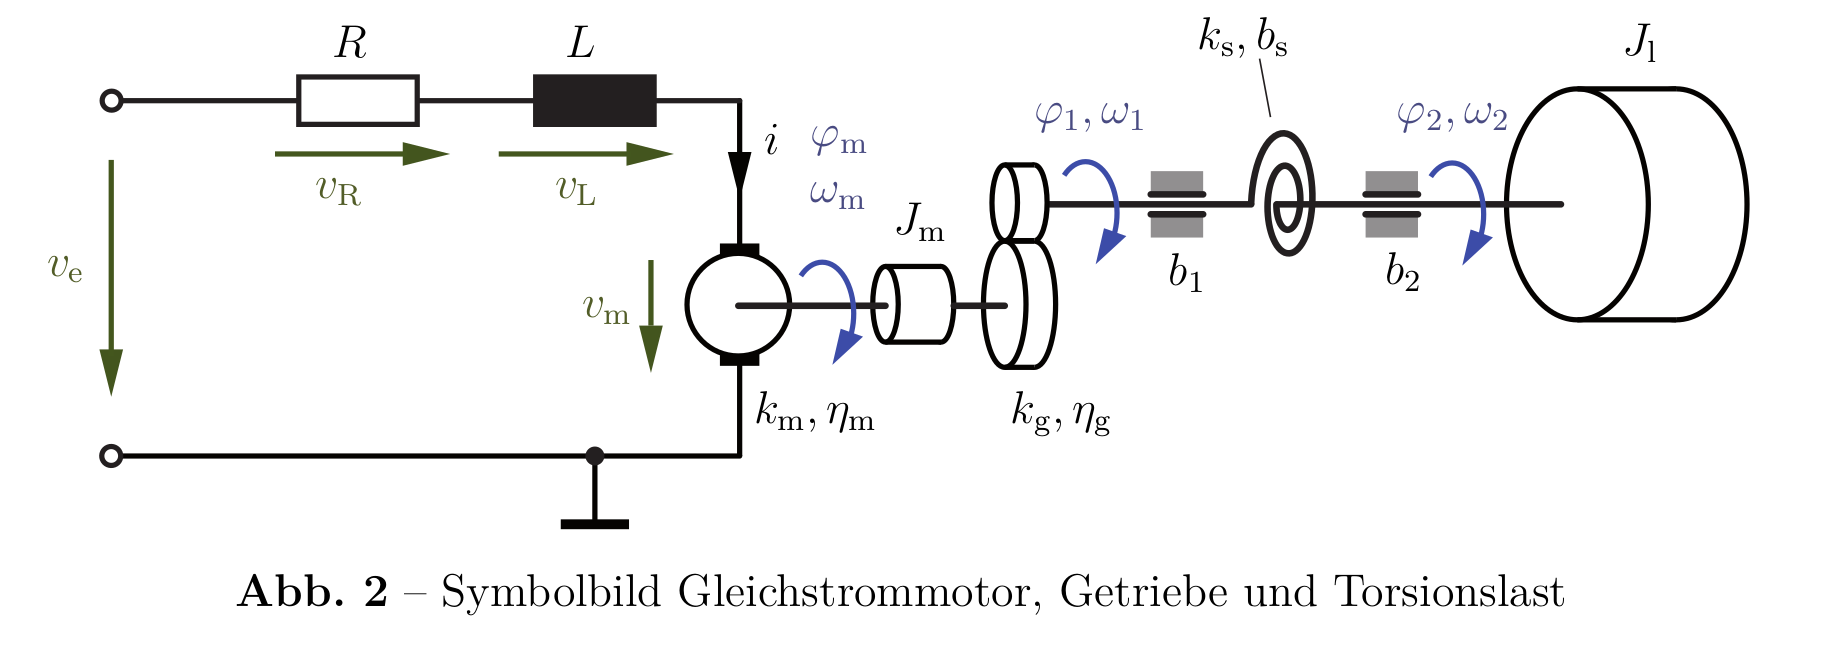

In [3]:
# Gerneral
N = 250                       # Stützstellen
Tend = 1                     # Zeithorizont [s]
t = np.linspace(0,Tend,N+1,endpoint=True)   # Gleichverteilung der Stützstellen --> alternative mit Variablen dt
dt = Tend/N
nx = 5
nu = 1

# Anfangsbedingungen und Endbedingungen

x0 = [0,0,0,0,0] 
xN = np.array([0,0,0,np.pi/2,0])
xf = np.transpose(np.array([xN]))
u0 = [0]

umax =  6
umin = -6


### 1.2.1 Zeitoptimale Trajektorie
$
\underset{u(),x()} {min}     \qquad   J(u,x) = \int_{t_{0}}^{t{f}} 1  dt \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$



In [4]:
topti = cas.casadi.Opti()

# Minimiere x und u
X = topti.variable(nx,N+1) # State vector [i,phi,omega]
U = topti.variable(nu,N+1)   # Control vector [u]
T = topti.variable()       # Final Time

#opti.minimize(T)
dt_T = T/N

# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_ex2_dynamic,X[:,k],U[:,k],dt_T)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt_T*libs.f_ex_dynamic(X[:,k],U[:,k])                 # Forwärtsintegration
   topti.subject_to(X[:,k+1] == xnew)



# Boundary Conditions
topti.subject_to(X[:,0] == x0)                        # Anfangsbedingung
#topti.subject_to(X[:,N] == xN)                       # Endbedingung
topti.subject_to(X[2:,N] == xN[2:])
topti.subject_to(X[0,N] == xN[0])

# ---- misc. constraints  ----------
topti.subject_to(T>0)                               # Time must be positive

# Path constraints

topti.subject_to(topti.bounded(umin,cas.vec(U),umax))

# Cost-function 
topti.minimize(T)         # Zeit


# Initial guess
#U1open = np.load('1_Daten/U1.npy')  #<-- needs 250 Stützstellen
#topti.set_initial(U[0,:],U1open) 
topti.set_initial(T, 0.25)


# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 1000}
topti.solver('ipopt', p_opts,s_opts)
sol_T = topti.solve()

X1 = sol_T.value(X)
U1 = sol_T.value(U)
T1 = sol_T.value(T)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    10009
Number of nonzeros in inequality constraint Jacobian.:      252
Number of nonzeros in Lagrangian Hessian.............:     1501

Total number of variables............................:     1507
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1259
Total number of inequality co

In [5]:
topti.debug

Opti(Opti {
  instance #0
  #variables: 3 (nx = 1507)
  #parameters: 0 (np = 0)
  #constraints: 255 (ng = 1511)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

Kosten Zeitoptimal :  0.20334590559543222
[ 0.         77.39070048  0.         90.          0.        ]


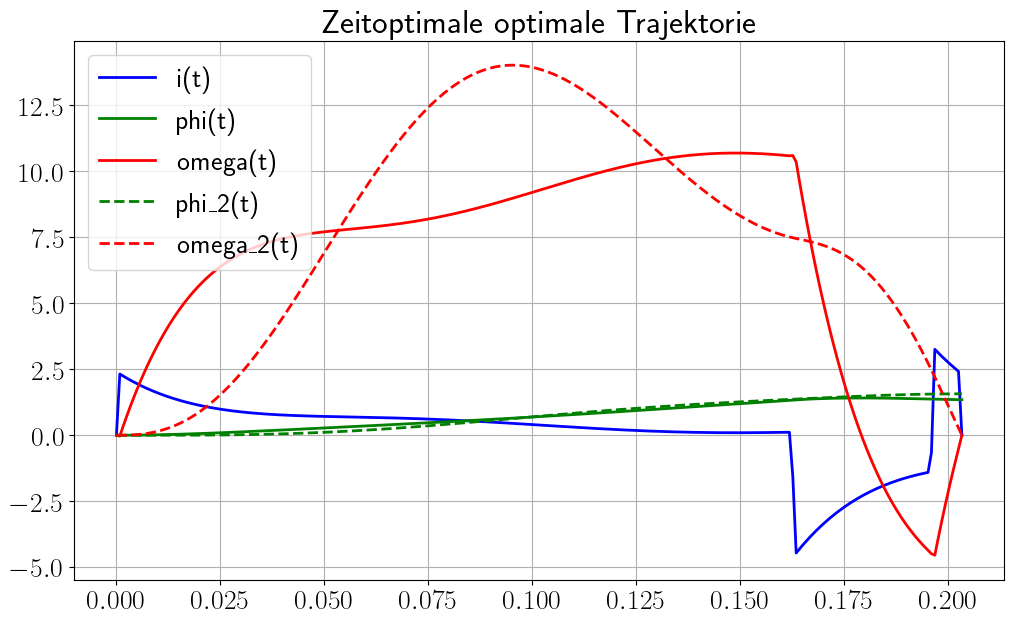

In [6]:
t1 = t*T1/Tend
print('Kosten Zeitoptimal : ',T1)
print(X1[:,-1]*180/np.pi)

plt.figure(figsize=(12,7))
plt.plot(t1,X1[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t1,X1[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t1,X1[2], 'r', linewidth ='2', label = 'omega(t)')
plt.plot(t1,X1[3], 'g', linewidth ='2', label = 'phi_{2}(t)', linestyle = '--')
plt.plot(t1,X1[4], 'r', linewidth ='2', label = 'omega_{2}(t)', linestyle='--')

plt.grid()
plt.legend(loc = 'best')
plt.title('Zeitoptimale optimale Trajektorie')

plt.show()

### 1.2.3 Quadratisches Gütemaß
$
\underset{u(),x()} {min}     \qquad   J(u,x) = x_{tf}^{T}Sx_{tf} + \int_{t_{0}}^{t{f}} (x^{T}Qx + u^{T}Ru)  dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \\
\qquad \qquad  g(x(t_{f}),u(t_{f})) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0
$

In [7]:
# Quadratisches Gütemaß
Q = np.diag([0, 0, 0, 20, 0.1])          # don't turn too sharply
R = np.diag([0.001])               # keep inputs small

S = np.diag([0, 0, 0, 50 ,0])             # get close to final point

In [8]:
# Cost function

def cost_quad(x,u,manual=False):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    
    cost = 0 #x[:,N].T@S@x[:,N]/2            # Endkostenterm 0.5*xSx
    for k in range(0,N-1):          
        if manual==False:
            cost += dt*((x[:,k].T-xf.T)@Q@(x[:,k]-xf))/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)      
        else:            
            cost += dt*((x[:,k].T-xN)@Q@(x[:,k]-xN))/2 

        cost += dt*u[k]*R*u[k]/2
            
    return cost

In [9]:
opti3 = cas.casadi.Opti()

# Minimiere x und u
X = opti3.variable(nx,N+1) # State vector 
U = opti3.variable(nu,N+1)   # Control vector 


# Dynamic Constraints
for k in range(N): # loop over control intervals   
   xnew = libs.runge_kutta_k4(libs.f_ex2_dynamic,X[:,k],U[:,k],dt)   # Runge-Kutta 4 integration  
   #xnew = X[:,k] + dt*f(X[:,k],U[:,k])              # Forwärtsintegration
   opti3.subject_to(X[:,k+1] == xnew)


# Boundary Conditions
opti3.subject_to(X[:,0] == x0)          # Anfangsbedingung
#opti3.subject_to(X[:,N-2:] == xN)          # Endbedingung
opti3.subject_to(X[2:,N] == xN[2:])
opti3.subject_to(X[0,N] == xN[0])

opti3.subject_to(U[:,0] == u0)          # Anfangseingang


# Path constraints
opti3.subject_to(opti3.bounded(umin,cas.vec(U),umax))


# ---- initial values for solver ---
#U3open = np.load('1_Daten/U3.npy')  #<-- needs 250 Stützstellen
#opti3.set_initial(U[0,:], U3open)


# Cost-function 
opti3.minimize(cost_quad(X,U))  # Quadratische Kostenfunktion


# Initial guess
#opti3.set_initial(U[0,:],6) 

# Solver#
p_opts = {"expand":True, "error_on_fail":False}
s_opts = {"max_iter": 3000}
opti3.solver('ipopt',p_opts, s_opts)
sol3 = opti3.solve()

X3 = sol3.value(X)
U3 = sol3.value(U)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8760
Number of nonzeros in inequality constraint Jacobian.:      251
Number of nonzeros in Lagrangian Hessian.............:      747

Total number of variables............................:     1506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1260
Total number of inequality constraints...............:      251
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      251
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4575315e+01 1.57e+00 1.26e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [10]:
opti3.debug.value

<bound method Opti.value of Opti(Opti {
  instance #1
  #variables: 2 (nx = 1506)
  #parameters: 0 (np = 0)
  #constraints: 255 (ng = 1511)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})>

Kosten Quadratisches Gütemasß :  [3.07307281]
[ 0.         89.99975133  0.         90.          0.        ]


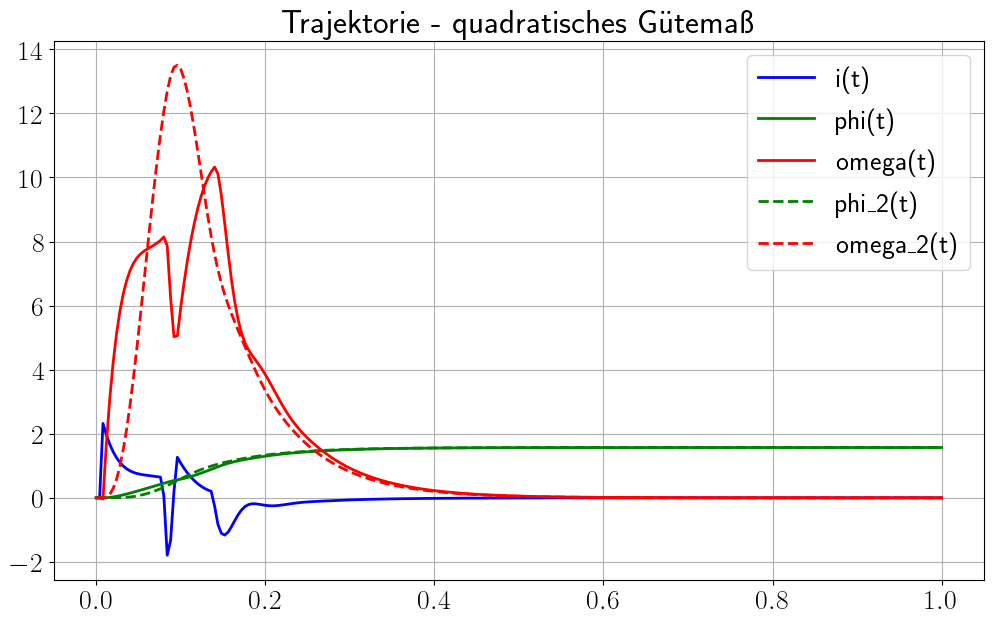

In [11]:
print('Kosten Quadratisches Gütemasß : ',cost_quad(X3,U3,True).flatten())
print(X3[:,-1]*180/np.pi)
plt.figure(figsize=(12,7))
plt.plot(t,X3[0], 'b', linewidth ='2', label = 'i(t)')
plt.plot(t,X3[1], 'g', linewidth ='2', label = 'phi(t)')
plt.plot(t,X3[2], 'r', linewidth ='2', label = 'omega(t)')
plt.plot(t,X3[3], 'g', linewidth ='2', label = 'phi_{2}(t)', linestyle = '--')
plt.plot(t,X3[4], 'r', linewidth ='2', label = 'omega_{2}(t)', linestyle='--')

plt.grid()
plt.legend(loc = 'best')
plt.title('Trajektorie - quadratisches Gütemaß')

plt.show()


## 1.3 Plots

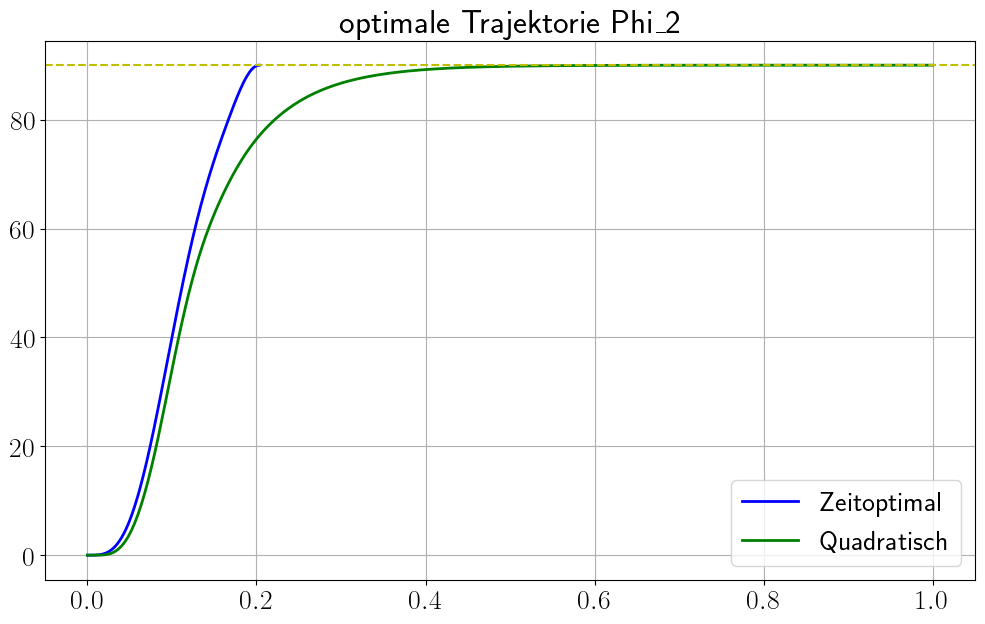

In [12]:
z = 3
name = ['Strom','Phi','Omega','Phi_{2}','Omega_{2}']
plt.figure(figsize=(12,7))
plt.plot(t1,X1[z]*180/np.pi, 'b', linewidth ='2', label = 'Zeitoptimal')
plt.plot(t,X3[z]*180/np.pi, 'g', linewidth ='2', label = 'Quadratisch')
plt.axhline(y=90, color='y', linestyle='--')
plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie '+name[z])

plt.show()

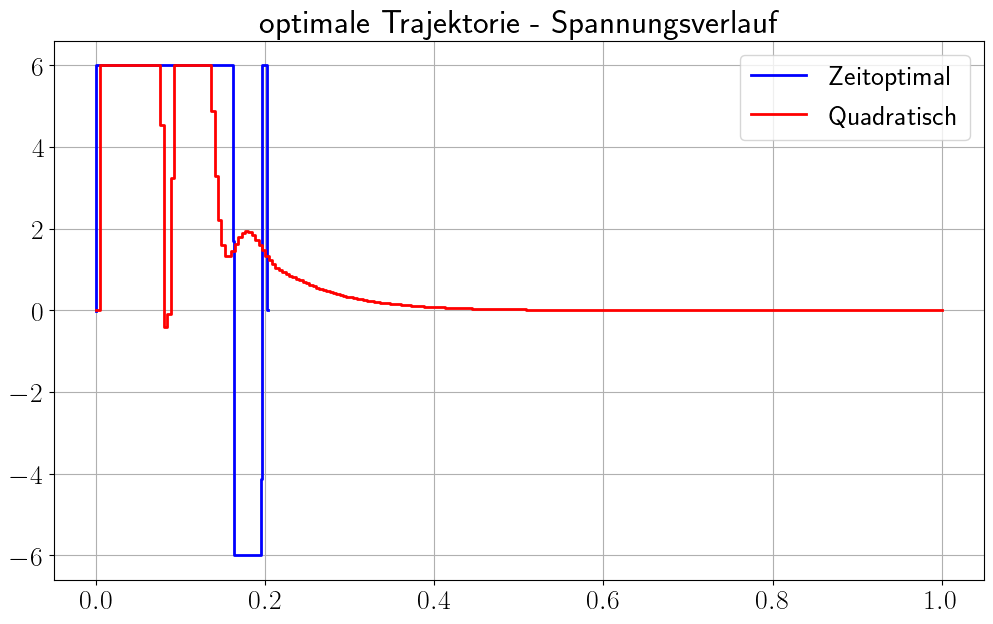

In [13]:
plt.figure(figsize=(12,7))

plt.step(t1,U1, 'b', linewidth ='2', label = 'Zeitoptimal')
plt.step(t,U3, 'r', linewidth ='2', label = 'Quadratisch')


plt.grid()
plt.legend(loc = 'best')
plt.title('optimale Trajektorie - Spannungsverlauf ')

plt.show()

# Überprüfung der Ergebnisse

## Export

In [14]:
# Export mit 1ms
dtexport = 1/1000
libs.exportTrajectForQuanser(X1[1],X1[2],U1,t1,dtexport,'Timeoptimal','2_Daten' )
libs.exportTrajectForQuanser(X3[1],X3[2],U3,t,dtexport,'Quad','2_Daten' )

In [18]:
import pandas as pd

# DataFrame erstellen
df = pd.DataFrame(X3[3]*180/np.pi)

# Excel-Datei exportieren
df.to_excel('dateiname.xlsx', index=False)
